In [1]:
from pmlb import fetch_data
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import WeightedRandomSampler
from training import pretrain_classifier, pretrain_adversary, train_debiased
from models import TabluarModel, MLP
from metrics import get_fairness_metrics
import torch.optim as optim
import pandas as pd
import numpy as np

In [2]:
# Returns a pandas DataFrame
adult_data = fetch_data('adult')
adult_data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39.0,7,77516.0,9,13.0,4,1,1,4,1,2174.0,0.0,40.0,39,1
1,50.0,6,83311.0,9,13.0,2,4,0,4,1,0.0,0.0,13.0,39,1
2,38.0,4,215646.0,11,9.0,0,6,1,4,1,0.0,0.0,40.0,39,1
3,53.0,4,234721.0,1,7.0,2,6,0,2,1,0.0,0.0,40.0,39,1
4,28.0,4,338409.0,9,13.0,2,10,5,2,0,0.0,0.0,40.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39.0,4,215419.0,9,13.0,0,10,1,4,0,0.0,0.0,36.0,39,1
48838,64.0,0,321403.0,11,9.0,6,0,2,2,1,0.0,0.0,40.0,39,1
48839,38.0,4,374983.0,9,13.0,2,10,0,4,1,0.0,0.0,50.0,39,1
48840,44.0,4,83891.0,9,13.0,0,1,3,1,1,5455.0,0.0,40.0,39,1


In [3]:
batch_size = 256
n_classes = 2

In [4]:
def make_weights_for_balanced_classes(x, nclasses):                        
    count = [0] * nclasses                                                      
    for item in x:
        count[item] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(x)                                              
    for idx, val in enumerate(x):
        weight[idx] = weight_per_class[val]                                  
    return weight  

In [5]:
x_df = adult_data.drop(columns=["target", "sex"])
x = x_df.values
y = adult_data["target"].values
s = adult_data["sex"].values
cat_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "native-country"]
embedding_sizes = [[len(x_df[ci].unique()), max(len(x_df[ci].unique())//4+1, 2)] for i,ci in enumerate(x_df.columns) if ci in cat_cols]
cat_idx = [i for i,ci in enumerate(x_df.columns) if ci in cat_cols]
cat_idx, embedding_sizes

([1, 3, 5, 6, 7, 8, 12],
 [[9, 3], [16, 5], [7, 2], [15, 4], [6, 2], [5, 2], [42, 11]])

In [6]:
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(x, y, s, test_size=0.2, random_state=1234, stratify=y)

In [7]:
ds_train = TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train), torch.LongTensor(s_train))
ds_test = TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test), torch.LongTensor(s_test))

In [8]:
batch_size = 256

# weights = make_weights_for_balanced_classes(y_train, n_classes)
# sampler = WeightedRandomSampler(weights, len(weights))
# train_loader = DataLoader(ds_train, batch_size=batch_size, sampler=sampler)

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [9]:
_, y_, _ = iter(train_loader).next()
y_.float().mean()

tensor(0.7812)

In [10]:
model_clf = TabluarModel(cat_idx, x_train.shape[1], embedding_sizes, [100, 100], n_classes)

In [11]:
optimizer_clf = optim.Adam(model_clf.parameters(), lr=0.005)
loss_criterion = torch.nn.CrossEntropyLoss()

In [12]:
model_clf = pretrain_classifier(model_clf, optimizer_clf, train_loader, loss_criterion, epochs=50, device="cpu")

torch.save(model_clf, "./saved/pretrain_classifier.pt")
model_clf = torch.load("./saved/pretrain_classifier.pt")

Average Clf epoch loss: 0.24609825385162254: 100%|█████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


Average Clf batch loss:  0.27924477106995055


In [13]:
yh = model_clf(torch.FloatTensor(x_train))
np.mean(yh.argmax(-1).numpy() == y_train)

0.8937885496378574

In [14]:
metrics_tr_init = get_fairness_metrics(yh.argmax(-1).numpy(), y_train, s_train)
metrics_tr_init

{'acc_diff': 0.09192207669343466,
 'bacc_diff': 0.035122737775656665,
 'AOD': 0.03512273777565664,
 'EOD': 0.0450371005950454,
 'SPD': 0.15967960657376368,
 'DI': 1.2131014688342217}

In [15]:
yh = model_clf(torch.FloatTensor(x_test))
np.mean(yh.argmax(-1).numpy() == y_test)

0.8457365134609479

In [17]:
metrics_ts_init = get_fairness_metrics(yh.argmax(-1).numpy(), y_test, s_test)
metrics_ts_init

{'acc_diff': 0.11139415385857265,
 'bacc_diff': 0.0031709051361707985,
 'AOD': 0.059035436757486404,
 'EOD': 0.06220634189365715,
 'SPD': 0.15653645201959543,
 'DI': 1.206902023458443}

In [18]:
y_train.mean(), y_test.mean()

(0.7607299157986334, 0.7606715119254785)

In [19]:
model_adv = MLP(2, [50, 50], 2)

optimizer_adv = optim.Adam(model_adv.parameters(), lr=0.001)
loss_criterion = torch.nn.CrossEntropyLoss()

model_adv = pretrain_adversary(model_adv, model_clf, optimizer_adv, train_loader, loss_criterion, epochs=100, device="cpu")

torch.save(model_adv, "./saved/pretrain_adv.pt")
model_adv = torch.load("./saved/pretrain_adv.pt")

Average Adv epoch loss: 0.5479579684781093: 100%|████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]

Average Adv batch loss:  0.5502857513521232


In [20]:
yh = model_clf(torch.FloatTensor(x_test))
sh = model_adv(yh)
np.mean(sh.argmax(-1).numpy() == s_test)

0.6816460231344047

In [21]:
yh = model_clf(torch.FloatTensor(x_train))
sh = model_adv(yh)
np.mean(sh.argmax(-1).numpy() == s_train)

0.6884037570700996

In [22]:
s_train.mean(), s_test.mean()

(0.6701302689836972, 0.6618896509366363)

In [23]:
model_clf, model_adv = train_debiased(model_clf, model_adv, train_loader, 3, 50, 10, 10, "cpu")

Average Clf epoch loss: 0.22026156317564397: 100%|█████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Average Clf batch loss:  0.22416872429886675


Average Adv epoch loss: 0.5565297038726558: 100%|██████████████████████████████████████| 10/10 [00:14<00:00,  1.46s/it]


Average Adv batch loss:  0.5564260836715013
Lambda: 3
Iteration:  0
Adversary Mini-Batch loss:  0.5496929287910461
Classifier Mini-Batch loss:  0.19349312782287598
Total Mini-Batch loss:  -1.4555857181549072
Iteration:  1
Adversary Mini-Batch loss:  0.5906127095222473
Classifier Mini-Batch loss:  0.20183944702148438
Total Mini-Batch loss:  -1.5699987411499023
Iteration:  2
Adversary Mini-Batch loss:  0.5650848746299744
Classifier Mini-Batch loss:  0.23251287639141083
Total Mini-Batch loss:  -1.462741732597351
Iteration:  3
Adversary Mini-Batch loss:  0.6262143850326538
Classifier Mini-Batch loss:  0.22659720480442047
Total Mini-Batch loss:  -1.6520459651947021
Iteration:  4
Adversary Mini-Batch loss:  0.541017472743988
Classifier Mini-Batch loss:  0.17696762084960938
Total Mini-Batch loss:  -1.44608473777771
Iteration:  5
Adversary Mini-Batch loss:  0.5755838751792908
Classifier Mini-Batch loss:  0.21777507662773132
Total Mini-Batch loss:  -1.5089764595031738
Iteration:  6
Adversary Mi

In [24]:
yh = model_clf(torch.FloatTensor(x_train))
np.mean(yh.argmax(-1).numpy() == y_train)

0.8881324699920662

In [25]:
metrics_tr_fin = get_fairness_metrics(yh.argmax(-1).numpy(), y_train, s_train)
metrics_tr_fin

{'acc_diff': 0.07755431598060358,
 'bacc_diff': 0.08149045682730893,
 'AOD': 0.08149045682730893,
 'EOD': 8.162742399620004e-05,
 'SPD': 0.10006688996983981,
 'DI': 1.1295821684950684}

In [26]:
yh = model_clf(torch.FloatTensor(x_test))
np.mean(yh.argmax(-1).numpy() == y_test)

0.8298699969290613

In [27]:
metrics_ts_fin = get_fairness_metrics(yh.argmax(-1).numpy(), y_test, s_test)
metrics_ts_fin

{'acc_diff': 0.09648583114695097,
 'bacc_diff': 0.04357253833417085,
 'AOD': 0.043572538334170935,
 'EOD': 0.014833617734509752,
 'SPD': 0.09093280869522302,
 'DI': 1.11647613728671}

<AxesSubplot:>

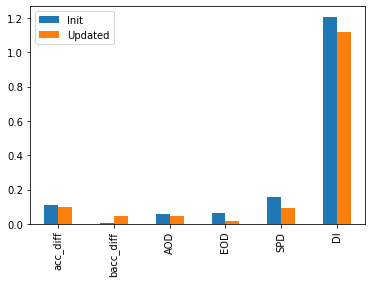

In [41]:
df = pd.DataFrame({k:[v] for k,v in metrics_ts_init.items()}, index=["Init"])
df = df.append(pd.DataFrame({k:[v] for k,v in metrics_ts_fin.items()}, index=["Updated"]))
df.T.plot.bar()